<a href="https://colab.research.google.com/github/Aditya8215/Aditya8215/blob/main/Trees_species_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# Step 2: Unzip dataset from Google Drive
import zipfile, os

zip_path = '/content/drive/MyDrive/zip_trees.zip'  # Update path if needed
extract_path = '/content/Tree_Species_Dataset'

In [60]:

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [64]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd
import os
import shutil

src = '/content/Tree_Species_Dataset/Tree_Species_Dataset'
dst = '/content/Updated_Tree_Species_Dataset'

os.makedirs(dst, exist_ok=True)

# List and sort folders to ensure consistent indexing
folders = sorted([f for f in os.listdir(src) if os.path.isdir(os.path.join(src, f)) and not f.startswith('.')])

# Copy all folders except the 20th one
for idx, folder in enumerate(folders):
    if idx == 20:
        print(f"Skipping 20th class: {folder}")
        continue
    full_path = os.path.join(src, folder)
    shutil.copytree(full_path, os.path.join(dst, folder))

In [7]:
import cv2
import os

folder_path = "/content/Tree_Species_Dataset/Tree_Species_Dataset/babul"
image_sizes = []

for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.png', '.jpeg')):
        img = cv2.imread(os.path.join(folder_path, filename))
        h, w = img.shape[:2]
        image_sizes.append((w, h))  # width, height

print("Unique sizes:", set(image_sizes))

Unique sizes: {(260, 194), (4000, 3000), (225, 224), (768, 1024), (1300, 866), (512, 384), (400, 274), (276, 183), (249, 202), (300, 168), (1800, 1347), (1024, 680), (259, 194), (280, 180), (248, 203), (800, 600), (1024, 768), (210, 240), (194, 259), (512, 288), (283, 178), (241, 209), (225, 225), (262, 192), (275, 183), (245, 206), (400, 400)}


# Data Retrival

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds,val_ds=image_dataset_from_directory(
    '/content/Updated_Tree_Species_Dataset',
    image_size=(224,224),
    batch_size=32,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    shuffle='True',
    seed=42,
)

Found 1450 files belonging to 29 classes.
Using 1160 files for training.
Using 290 files for validation.


# Data Augmentation

In [9]:
# help(ImageDataGenerator)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_augmen1=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='reflect',
    validation_split=0.2,
)
test_augmen1=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [11]:
train_generator=train_augmen1.flow_from_directory(
    '/content/Updated_Tree_Species_Dataset',
    target_size=(320,320),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)
val_generator=test_augmen1.flow_from_directory(
    '/content/Updated_Tree_Species_Dataset',
    target_size=(320,320),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 1160 images belonging to 29 classes.
Found 290 images belonging to 29 classes.


In [12]:
import numpy as np
np.unique(train_generator.classes, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=int32),
 array([40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
        40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]))

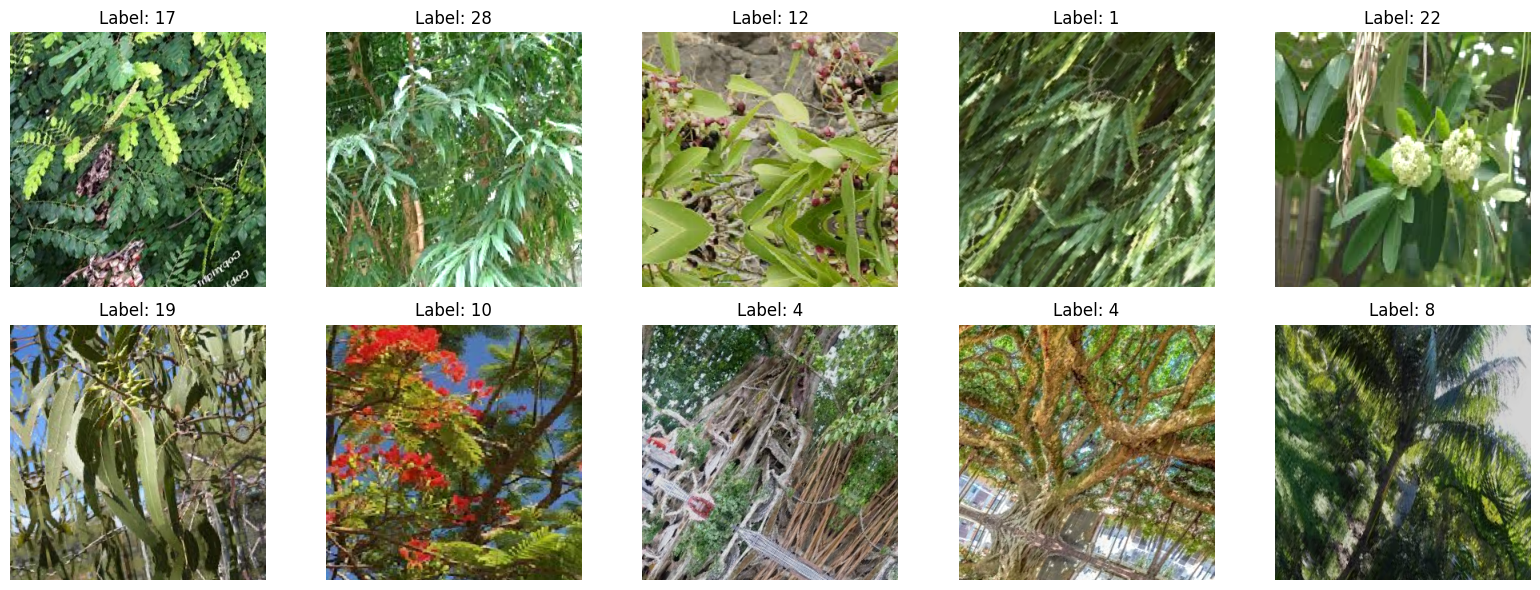

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch one batch
images, labels = next(train_generator)

# Plot the first 10 images and their labels
plt.figure(figsize=(16, 6))
for i in range(10):
    img = images[i]
    label = np.argmax(labels[i])  # Convert one-hot to class index
    plt.subplot(2, 5, i + 1)
    plt.imshow((img * 255).astype("uint8"))
    plt.axis('off')
    plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

# Using CNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(320,320, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 318, 318, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 318, 318, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 159, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 157, 157, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 76, 76, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 76, 76, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 184832)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,658,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,756,509 (90.62 MB)

 Trainable params: 23,756,061 (90.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/best_tree_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.0288 - loss: 25.3276

37/37 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.0289 - loss: 25.0077 - val_accuracy: 0.0379 - val_loss: 23.5432
Epoch 2/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 906ms/step - accuracy: 0.0271 - loss: 3.3782 - val_accuracy: 0.0448 - val_loss: 46.8306
Epoch 3/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 933ms/step - accuracy: 0.0262 - loss: 3.3693 - val_accuracy: 0.0310 - val_loss: 33.2449
Epoch 4/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 905ms/step - accuracy: 0.0410 - loss: 3.5223 - val_accuracy: 0.0379 - val_loss: 61.2951
Epoch 5/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.0362 - loss: 3.5411

37/37 ━━━━━━━━━━━━━━━━━━━━ 42s 946ms/step - accuracy: 0.0362 - loss: 3.5403 - val_accuracy: 0.0345 - val_loss: 9.0295
Epoch 6/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 898ms/step - accuracy: 0.0410 - loss: 3.5453 - val_accuracy: 0.0207 - val_loss: 29.5688
Epoch 7/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.0306 - loss: 3.6599

37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 954ms/step - accuracy: 0.0305 - loss: 3.6574 - val_accuracy: 0.0310 - val_loss: 5.0864
Epoch 8/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.0297 - loss: 3.3673

37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 961ms/step - accuracy: 0.0297 - loss: 3.3673 - val_accuracy: 0.0345 - val_loss: 3.6744
Epoch 9/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 946ms/step - accuracy: 0.0222 - loss: 3.3990 - val_accuracy: 0.0276 - val_loss: 4.1117
Epoch 10/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0360 - loss: 3.3672

37/37 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.0360 - loss: 3.3673 - val_accuracy: 0.0310 - val_loss: 3.3868
Epoch 11/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0412 - loss: 3.3673

37/37 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.0410 - loss: 3.3673 - val_accuracy: 0.0345 - val_loss: 3.3725
Epoch 12/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0274 - loss: 3.3677

37/37 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.0276 - loss: 3.3677 - val_accuracy: 0.0345 - val_loss: 3.3672
Epoch 13/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 964ms/step - accuracy: 0.0411 - loss: 3.3673 - val_accuracy: 0.0345 - val_loss: 3.3673
Epoch 14/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 915ms/step - accuracy: 0.0367 - loss: 3.3671 - val_accuracy: 0.0345 - val_loss: 3.3673
Epoch 15/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.0349 - loss: 3.3673 - val_accuracy: 0.0345 - val_loss: 3.3673
Epoch 16/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.0352 - loss: 3.3675 - val_accuracy: 0.0345 - val_loss: 3.3673
Epoch 17/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.0292 - loss: 3.3676 - val_accuracy: 0.0345 - val_loss: 3.3673


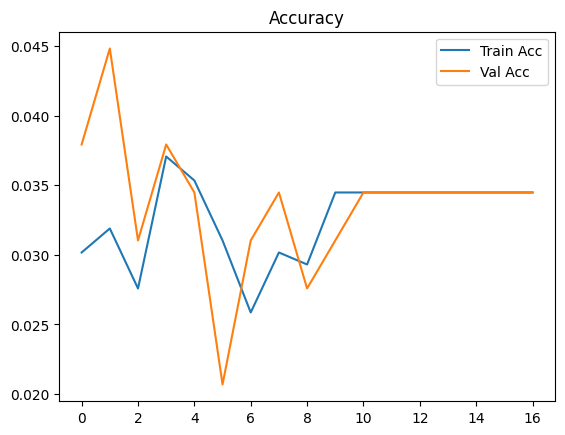

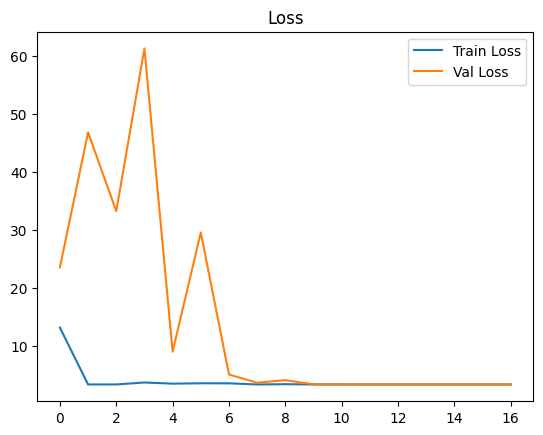

In [17]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [18]:
model.save('/content/final_tree_model.h5')
print("✅ Final model saved at /content/final_tree_model.h5")

✅ Final model saved at /content/final_tree_model.h5


# Use Transfer Learning-

In [19]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import DenseNet121,DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [20]:
base_model=DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(320,320,3)
)
base_model.model_trainable=True
set_trainable=True

for layer in base_model.layers[:-90]:
    layer.trainable=False

# for layer in base_model.layers:
#     print(layer.name,layer.trainable)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(29,activation='softmax'),
])
model.compile(optimizer=Adam(0.001),metrics=['accuracy'],loss='categorical_crossentropy')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 10, 10, 1920)   │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       983,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,455,069 (74.22 MB)

 Trainable params: 4,284,829 (16.35 MB)

 Non-trainable params: 15,170,240 (57.87 MB)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping


early = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [23]:
history=model.fit(train_generator,validation_data=val_generator,epochs=50,batch_size=32,verbose=1,callbacks=[early])

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.1419 - loss: 3.5164 - val_accuracy: 0.2690 - val_loss: 3.4128
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4923 - loss: 1.7908 - val_accuracy: 0.5345 - val_loss: 1.9921
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6008 - loss: 1.3284 - val_accuracy: 0.6793 - val_loss: 1.3193
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6707 - loss: 1.0810 - val_accuracy: 0.6724 - val_loss: 1.4490
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7366 - loss: 0.9178 - val_accuracy: 0.7241 - val_loss: 1.0802
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7940 - loss: 0.7156 - val_accuracy: 0.7172 - val_loss: 1.0858
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7973 - loss: 0.6193 - val_accuracy: 0.7483 - val_loss: 1.0533
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8331 - loss: 0.5746 - val_accuracy: 0.7345 - val_loss

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.show()

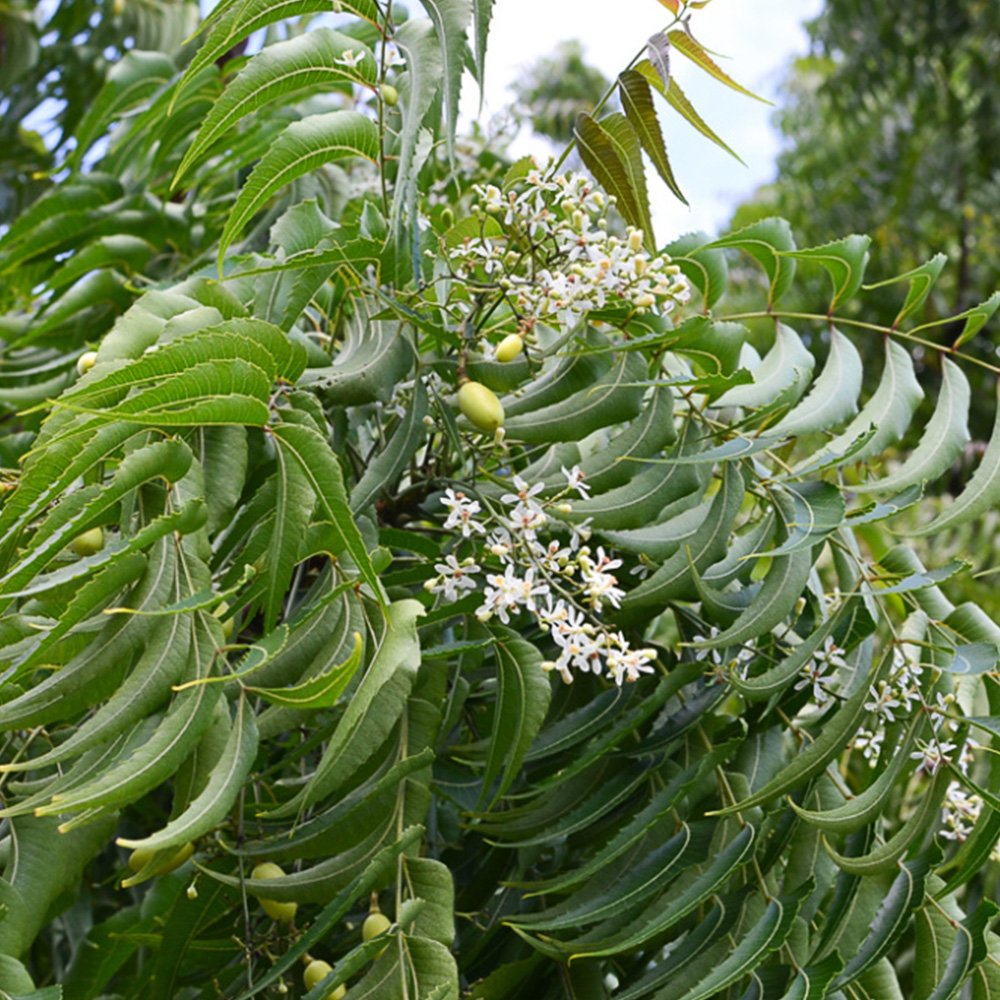

In [26]:
from PIL import Image
from IPython.display import display
path='/content/Neem.jpg'
img=Image.open(path)
display(img)

In [27]:
from tensorflow.keras.preprocessing import image
img = image.load_img(path, target_size=(320, 320))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)
y_pred=model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


In [28]:
ans=np.argmax(y_pred)
ans

np.int64(18)

In [29]:
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

Class names: ['amla', 'asopalav', 'babul', 'bamboo', 'banyan', 'bili', 'cactus', 'champa', 'coconut', 'garmalo', 'gulmohor', 'gunda', 'jamun', 'kanchan', 'kesudo', 'khajur', 'mango', 'motichanoti', 'neem', 'nilgiri', 'pilikaren', 'pipal', 'saptaparni', 'shirish', 'simlo', 'sitafal', 'sonmahor', 'sugarcane', 'vad']


In [30]:
for i in range(len(class_names)):
    if i==ans:
        print(class_names[i])

neem


In [31]:
try:
    model.save("tree_species_model.h5")
    print("Model saved successfully.")
except Exception as e:
    print("Error:", e)

Model saved successfully.


In [ ]:
# from tensorflow.keras.models import load_model
# model1 = load_model('densenet.h5')

# Using Vision Transformers

In [ ]:
# https://colab.research.google.com/drive/1xKrc9Xmmx2nLZllaBT5xzxQM3SCgboVy#scrollTo=tO6_herOv-3S